# Robustness Tests on the Best Performing Strategy Modification

In [17]:
# auto reload
%load_ext autoreload
%autoreload 2

# Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import core_metrics, file_exports, strategies, robustness_tests
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Select the Most Profitable Refinement

In [18]:
directory_path = Path('../data/strategy_results/')

max_return = 0
max_portfolio_value = 0
max_return_filename = ""

for file_path in directory_path.iterdir():
    if "baseline" in str(file_path):
        continue
    try: 
        prices_df = pd.read_csv(file_path)
        portfolio = prices_df['portfolio_value'].iloc[-1]
        invt_amount = prices_df['portfolio_value'].iloc[1]
        strategy_return = (portfolio - invt_amount) / invt_amount
        if strategy_return > max_return:
            max_return = strategy_return
            max_portfolio_value = portfolio
            max_return_filename = file_path
    except Exception as e:
        print(f'Failed to fetch file {file_path}: {e}')
        continue
print(f'''Best performing portfolio: {max_return_filename}, with total return of {(max_return*100):.2f}% 
      and final portfolio value of {max_portfolio_value}.''')

Best performing portfolio: ../data/strategy_results/ma_position_resizing.csv, with total return of 64.75% 
      and final portfolio value of 16475.420205960098.


# Robustness Tests

In [19]:
from robustness_tests import (
    walk_forward_analysis,
    parameter_sensitivity,
    regime_analysis,
    monte_carlo_block_bootstrap
)
from strategies import ma_position_resize

### 1. Out-of-Sample Analysis

In [20]:
from strategies import ma_position_resize

# fetch test data (latter 30% of all data)
csv_path = "../data/processed/test_data_30.csv"
test_data = pd.read_csv(csv_path)
investment = 10000
short_ma = 20
long_ma = 50
vol_threshold = .75
out_of_sample_result = ma_position_resize(investment, test_data, short_ma, long_ma, vol_threshold)

In [21]:
out_of_sample_result.tail()

,Open,High,Low,Close,Volume,MA_short,MA_long,TR,ATR,ATR_pct,...,position,trade_cost,market_ret,strategy_ret,strategy_ret_net,market_ret_net,cumulative_market,cumulative_strategy,portfolio_value,market_portfolio_value
Date,,,,,,,,,,,,,,,,,,,,,
2025-12-23,683.919983,688.200012,683.869995,687.960022,64840000,680.287195,674.352507,4.330017,6.617051,0.009618,...,0.0,0.0,0.004570,0.004050,0.004050,0.004570,1.775508,1.328746,13287.456550,17755.079473
2025-12-24,687.950012,690.830017,687.799988,690.380005,39445600,681.154633,674.954529,3.030029,6.138782,0.008892,...,0.0,0.0,0.003518,0.003117,0.003117,0.003518,1.781754,1.332887,13328.873304,17817.535121
2025-12-26,690.640015,691.659973,689.270020,690.309998,41613300,681.786255,675.496523,2.389954,5.638938,0.008169,...,0.0,0.0,-0.000101,-0.000090,-0.000090,-0.000101,1.781573,1.332768,13327.675643,17815.728351
2025-12-29,687.539978,689.200012,686.070007,687.849976,62559500,682.109924,676.079650,4.239990,5.452412,0.007927,...,0.0,0.0,-0.003564,-0.003158,-0.003158,-0.003564,1.775224,1.328559,13285.589964,17752.239363
2025-12-30,687.450012,688.559998,686.580017,687.010010,47160700,682.547134,676.571198,1.979980,4.989421,0.007263,...,0.0,0.0,-0.001221,-0.001082,-0.001082,-0.001221,1.773056,1.327121,13271.214104,17730.561272


Final portfolio value: 13271.214104043822 on 2025-12-30 00:00:00
Strategy returned 32.712141040438226% from 2022-09-09 00:00:00 to 2025-12-30 00:00:00
Market returned 77.30561272268599 from 2022-09-09 00:00:00 to 2025-12-30 00:00:00

Annualized across 3.3073 years: 
MA Strategy with Position Resizing returned 8.9339% per year
Buy & Hold the market returned 18.9059% per year


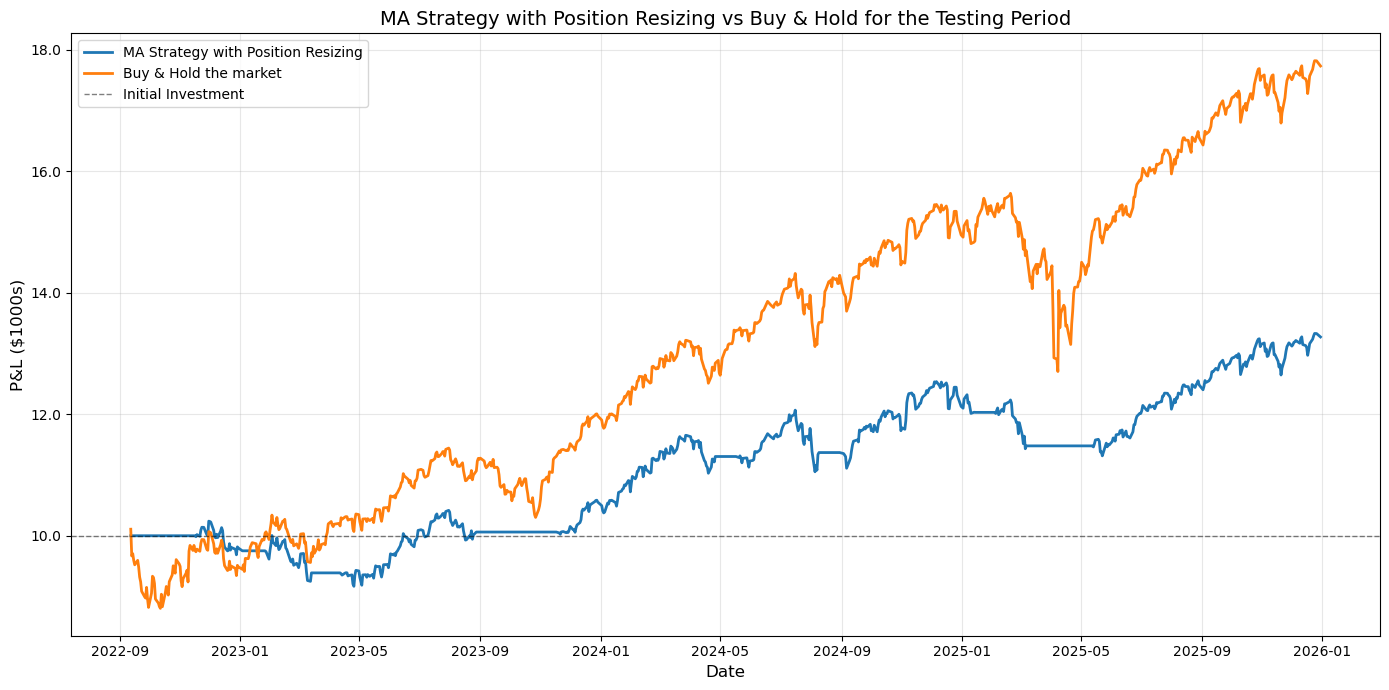

In [22]:
from core_metrics import pnl

graph_title = 'MA Strategy with Position Resizing vs Buy & Hold for the Testing Period'
strategy_name = "MA Strategy with Position Resizing"
benchmark_name = "Buy & Hold the market"

out_of_sample_result, strategy_annual_return, market_annual_return = pnl(out_of_sample_result, investment, strategy_name, benchmark_name, graph_title)

### 2. Walk-Forward Analysis


Window 1:
  Train: 2015-01-01 to 2018-12-31
  Test:  2019-01-01 to 2020-12-31
  ATR threshold (from train): 0.0109

  Test Results:
    Total Return: 11.70% (This is also annual return)
    Sharpe: 0.03
    Sharpe With Costs: 0.03
    Max Drawdown: -12.69%
    Trades: 10

Window 2:
  Train: 2015-01-01 to 2019-12-31
  Test:  2020-01-01 to 2021-12-31
  ATR threshold (from train): 0.0112

  Test Results:
    Total Return: 32.68% (This is also annual return)
    Sharpe: 0.10
    Sharpe With Costs: 0.09
    Max Drawdown: -6.09%
    Trades: 6

Window 3:
  Train: 2015-01-01 to 2020-12-31
  Test:  2021-01-01 to 2022-12-31
  ATR threshold (from train): 0.0134

  Test Results:
    Total Return: -10.91% (This is also annual return)
    Sharpe: -0.04
    Sharpe With Costs: -0.05
    Max Drawdown: -22.91%
    Trades: 10

Window 4:
  Train: 2015-01-01 to 2021-12-31
  Test:  2022-01-01 to 2023-12-31
  ATR threshold (from train): 0.0132

  Test Results:
    Total Return: -7.18% (This is also annual r

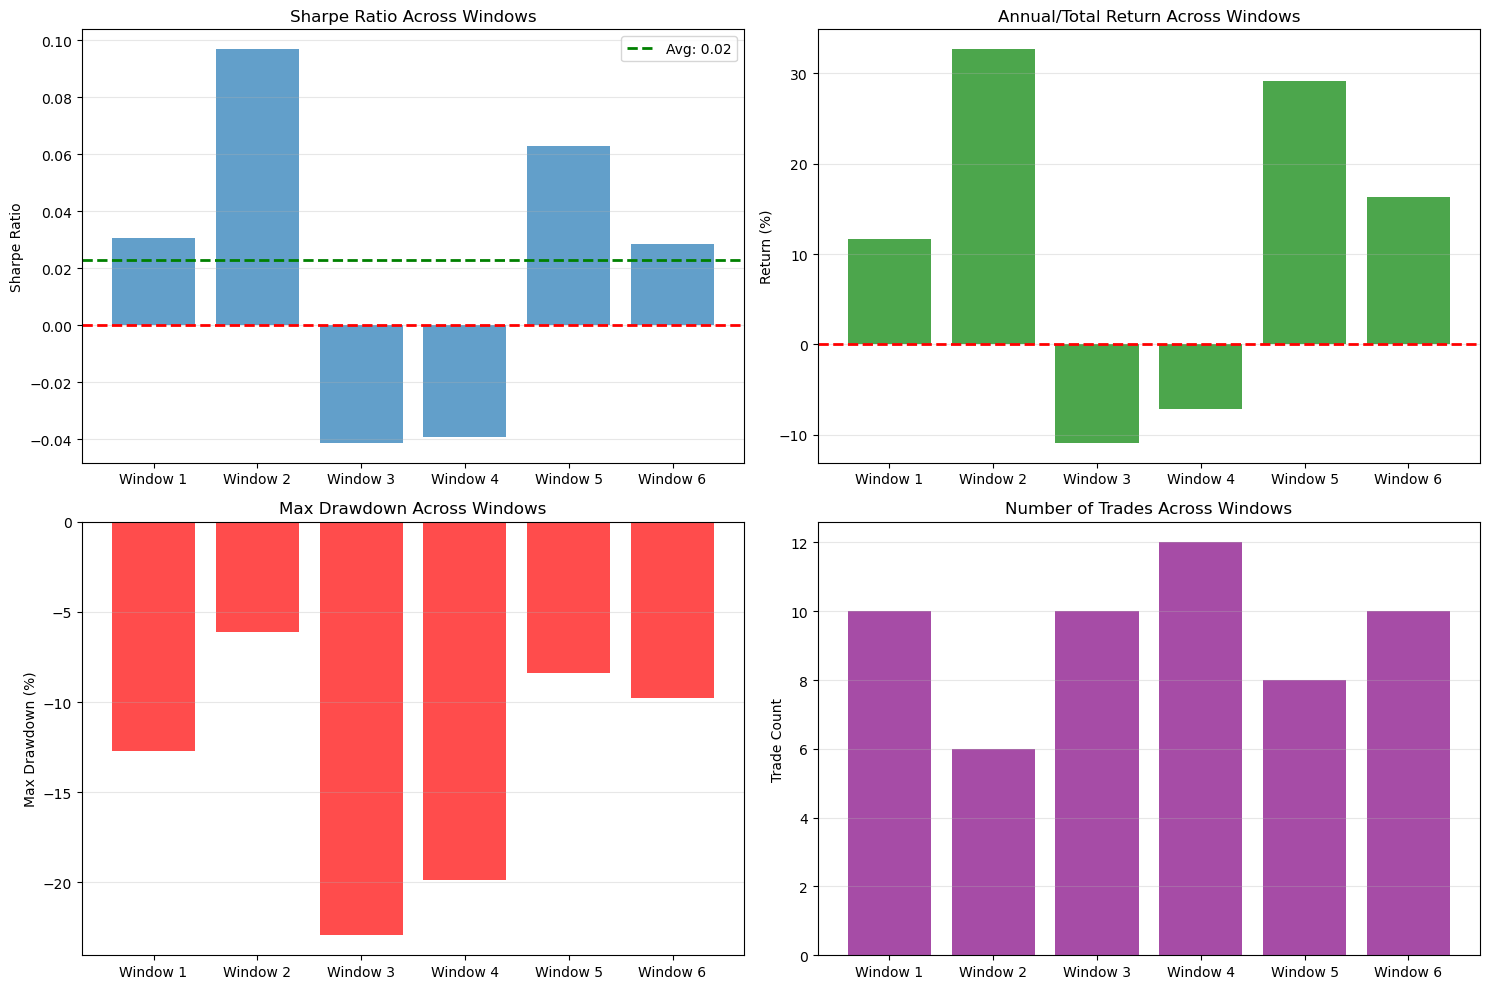

In [23]:
spy_filename = "../data/processed/spy.csv"
spy_prices_df = pd.read_csv(spy_filename, index_col=0, parse_dates=True)
wf_results = walk_forward_analysis(prices_df=spy_prices_df, investment=10000, short_ma=20, long_ma=50)

### 3. Monte Carlo Simulation

MONTE CARLO BLOCK BOOTSTRAP (1,000 simulations)
Block size: 20 days
  Progress: 0/1000
  Progress: 100/1000
  Progress: 200/1000
  Progress: 300/1000
  Progress: 400/1000
  Progress: 500/1000
  Progress: 600/1000
  Progress: 700/1000
  Progress: 800/1000
  Progress: 900/1000
Figure saved to: ../results/figures/monte_carlo.png


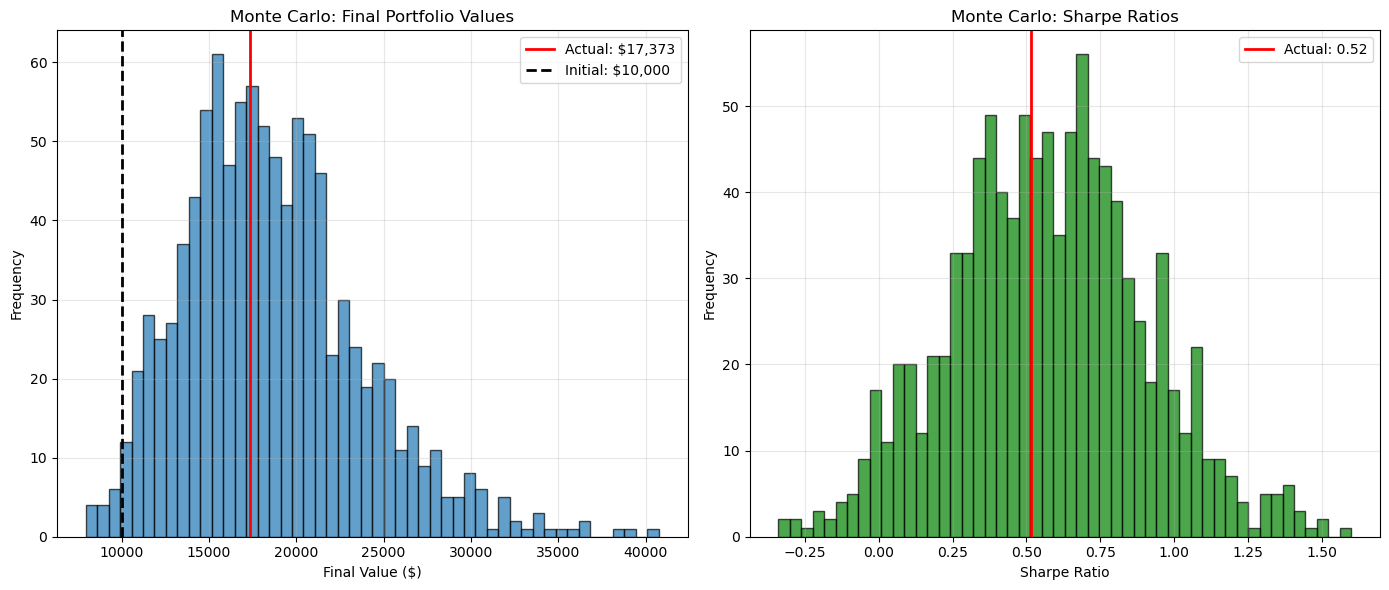


Actual final value: $17,372.86
Simulated mean: $18,631.74
Simulated 5th percentile: $11,374.34
Simulated 95th percentile: $27,904.40

Actual Sharpe: 0.52
Simulated mean Sharpe: 0.57

% of simulations beating actual value: 55.7%
% of simulations beating actual Sharpe: 56.4%

✗ Result not significant - may be due to luck


In [24]:
baseline_result = pd.read_csv('../data/strategy_results/ma_baseline_strategy.csv', index_col=0, parse_dates=True)

mc_results = monte_carlo_block_bootstrap(baseline_result, 10000, n_simulations=1000)

### 4. Parameter Sensitivity

PARAMETER SENSITIVITY ANALYSIS - POSITION SIZING

1. Testing MA period sensitivity (atr_cutoff fixed at 0.75)...
  MA(15,40): Sharpe=0.39, Return=6.18%
  MA(18,45): Sharpe=0.41, Return=6.50%
  MA(20,50): Sharpe=0.45, Return=7.03%
  MA(22,55): Sharpe=0.46, Return=7.32%
  MA(25,60): Sharpe=0.40, Return=6.64%

2. Testing ATR cutoff sensitivity (MA fixed at 20/50)...
  ATR Cutoff 60%: Sharpe=0.41, Return=6.30%, Avg Position=89.3%
  ATR Cutoff 65%: Sharpe=0.42, Return=6.55%, Avg Position=92.0%
  ATR Cutoff 70%: Sharpe=0.43, Return=6.76%, Avg Position=94.3%
  ATR Cutoff 75%: Sharpe=0.45, Return=7.03%, Avg Position=96.3%
  ATR Cutoff 80%: Sharpe=0.46, Return=7.20%, Avg Position=97.7%


KeyboardInterrupt: 

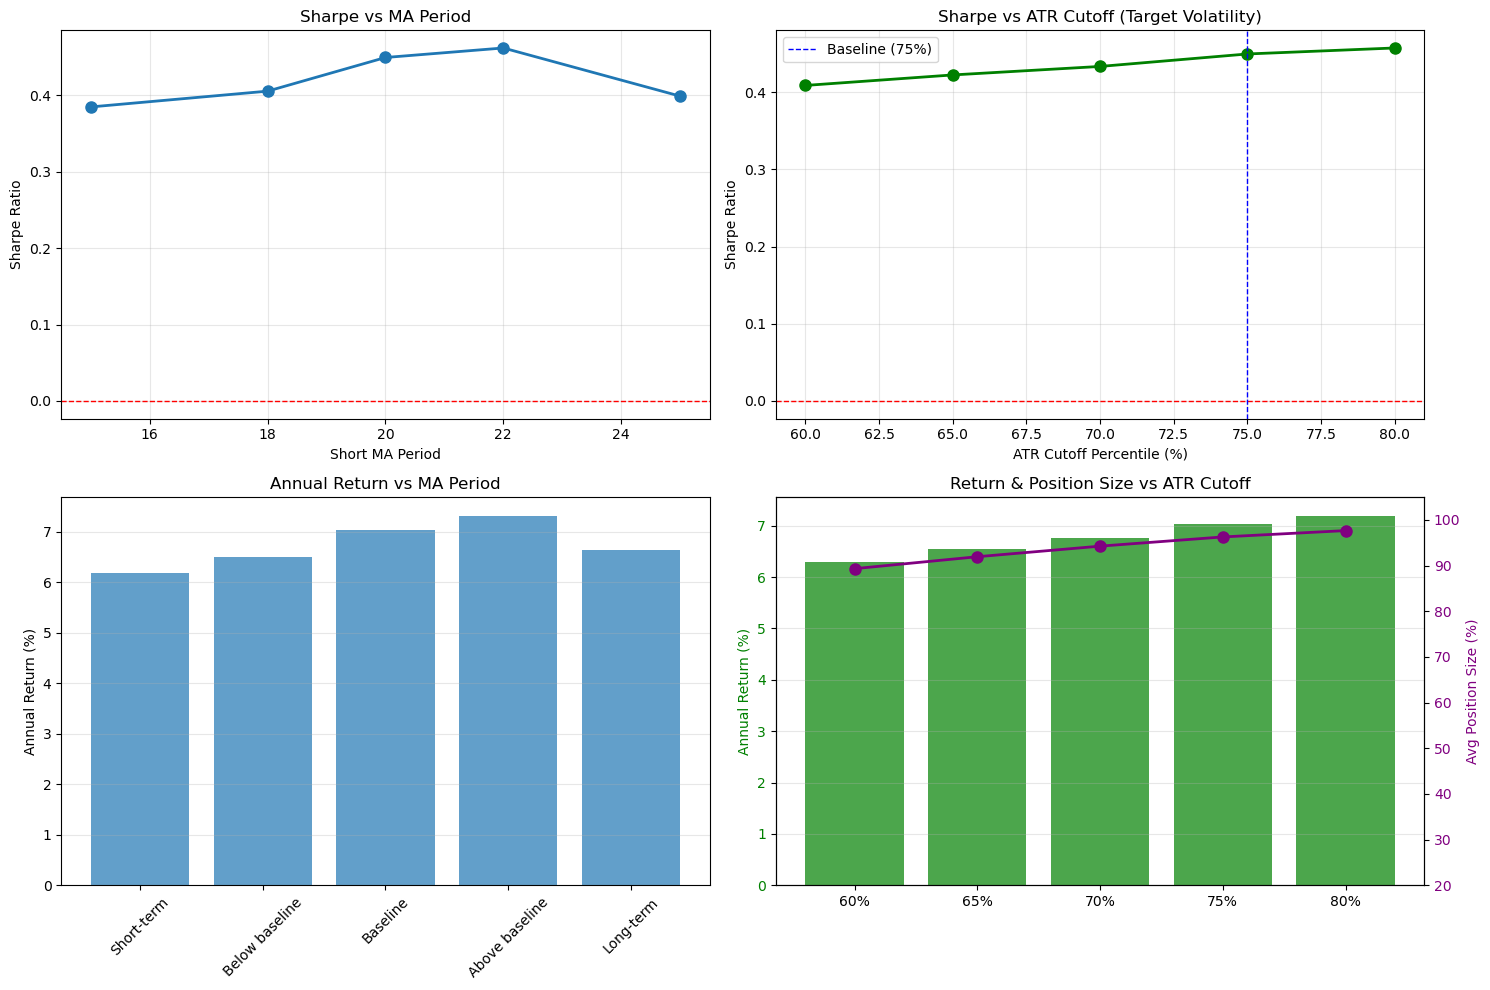

In [25]:
param_results = parameter_sensitivity(ma_position_resize, 10000, spy_prices_df)


### 5. Regime Analysis

MARKET REGIME ANALYSIS

Bull Market 2016-2018:
  Period: 2016-01-04 to 2018-12-31
  Strategy: 10.56% annual
  Buy&Hold: 9.71% annual
  ✓ Outperformed

Correction 2018:
  Period: 2018-10-01 to 2018-12-31
  Strategy: 0.00% annual
  Buy&Hold: -44.98% annual
  ✓ Outperformed

Bull Market 2019:
  Period: 2019-01-02 to 2019-12-31
  Strategy: 5.54% annual
  Buy&Hold: 31.31% annual
  ✗ Underperformed

COVID Recovery:
  Period: 2020-04-01 to 2020-12-31
  Strategy: 30.29% annual
  Buy&Hold: 77.54% annual
  ✗ Underperformed

Bull 2021:
  Period: 2021-01-04 to 2021-12-31
  Strategy: 13.77% annual
  Buy&Hold: 30.92% annual
  ✗ Underperformed

Bear Market 2022:
  Period: 2022-01-03 to 2022-12-30
  Strategy: -17.66% annual
  Buy&Hold: -18.84% annual
  ✓ Outperformed

Recovery 2023+:
  Period: 2023-01-03 to 2024-12-31
  Strategy: 13.40% annual
  Buy&Hold: 25.89% annual
  ✗ Underperformed
Figure saved to: ../results/figures/regime_analysis.png


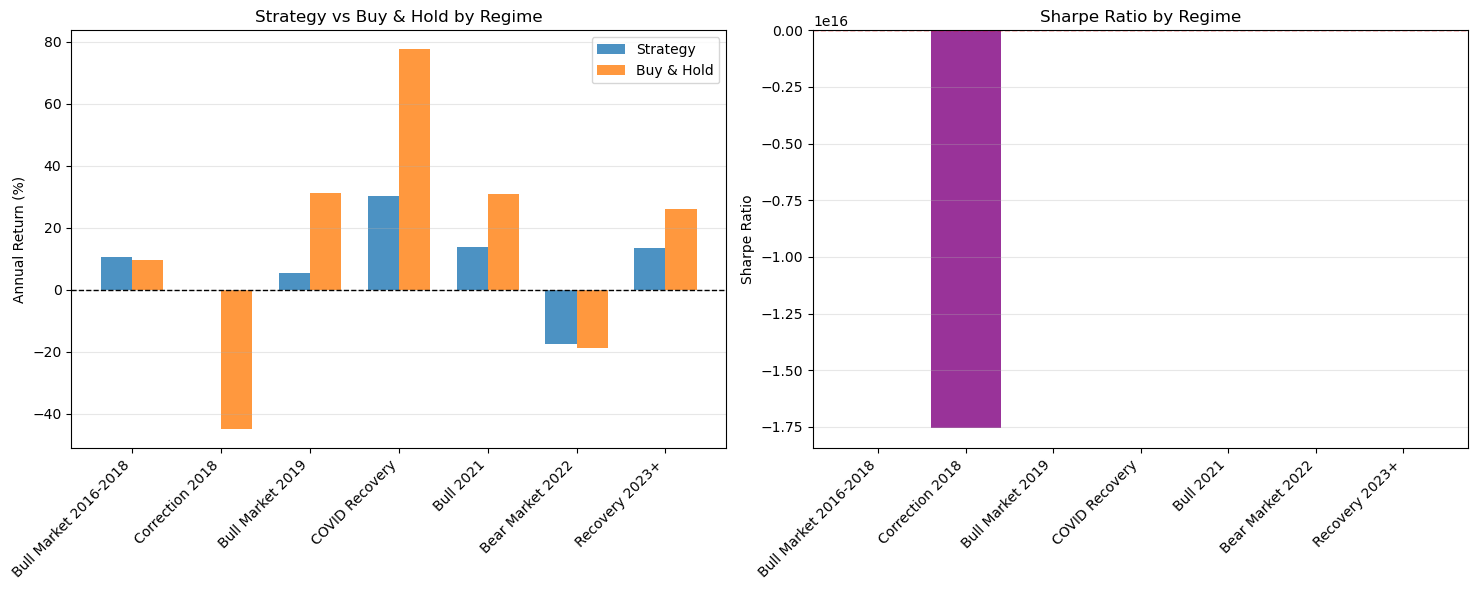


REGIME SUMMARY
Outperformed in 3 / 7 regimes
Average outperformance: -7.95%


In [26]:
regime_result = regime_analysis(spy_prices_df, ma_position_resize, inv_amt=10000, short_ma=20, long_ma=50)